# Bayesian Change Point Analysis of Brent Oil Prices

This notebook demonstrates how to detect structural breaks in Brent oil prices using Bayesian methods (PyMC3), visualize the data, and associate change points with major events. All code and explanations are provided for reproducibility and expert-level insight.

In [2]:
# Install required libraries (uncomment if running in a new environment)
# !pip install pandas numpy matplotlib seaborn pymc3

# List required libraries
required_libs = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'pymc3']
print('Required libraries:', required_libs)

Required libraries: ['pandas', 'numpy', 'matplotlib', 'seaborn', 'pymc3']


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

# Set visualization style
sns.set(style='whitegrid')

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [4]:
# Load Brent oil price data
brent_df = pd.read_csv('../data/BrentOilPrices.csv')
brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce', infer_datetime_format=True)
brent_df = brent_df.sort_values('Date')
brent_df.head()

C:\Users\pc\AppData\Local\Temp\ipykernel_13020\2642387652.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce', infer_datetime_format=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_13020\2642387652.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce', infer_datetime_format=True)


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


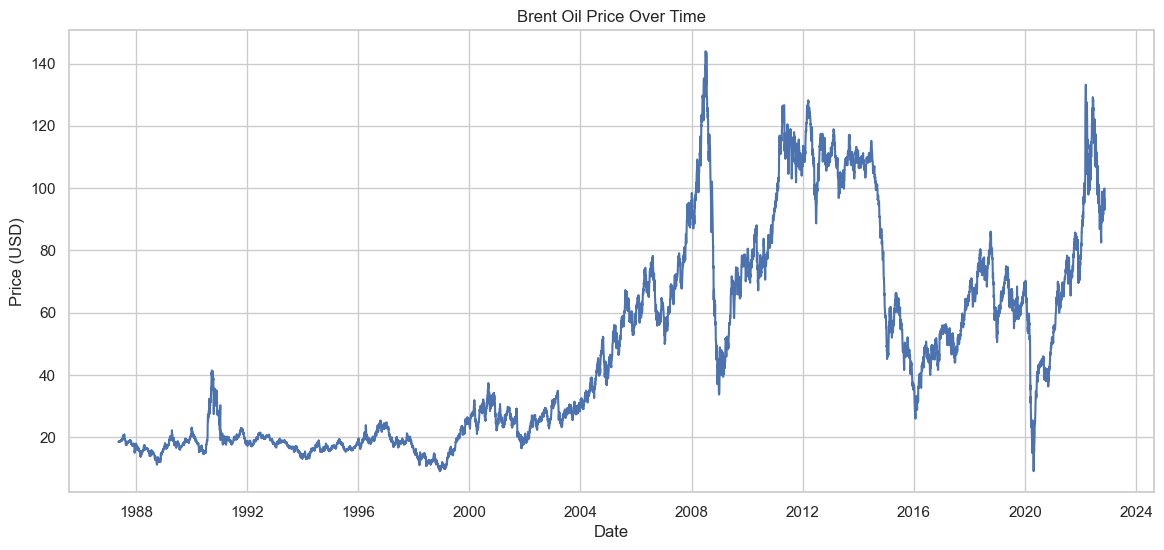

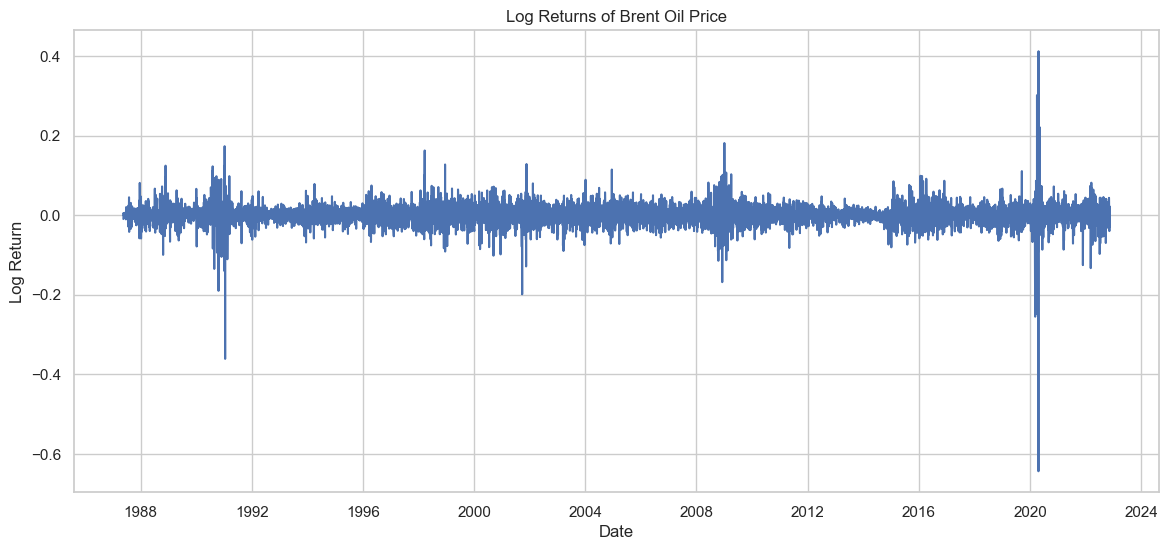

In [5]:
# Visualize Brent oil price time series
plt.figure(figsize=(14, 6))
plt.plot(brent_df['Date'], brent_df['Price'])
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

# Compute log returns
prices = brent_df['Price'].values
log_returns = np.log(prices[1:] / prices[:-1])
dates = brent_df['Date'].values[1:]

# Plot log returns
plt.figure(figsize=(14, 6))
plt.plot(dates, log_returns)
plt.title('Log Returns of Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

In [ ]:
# Quantify impact
mu_1_samples = trace['mu_1']
mu_2_samples = trace['mu_2']
mean_before = np.mean(mu_1_samples)
mean_after = np.mean(mu_2_samples)
print(f"Mean log return before change: {mean_before:.5f}")
print(f"Mean log return after change: {mean_after:.5f}")
impact = (mean_after - mean_before) / abs(mean_before) * 100
print(f"Percent change in mean log return: {impact:.2f}%")

# Associate with events
events = pd.read_csv('../event_data/events.csv')
events['Date'] = pd.to_datetime(events['Date'])
window = pd.Timedelta(days=30)
nearby_events = events[(events['Date'] >= change_date - window) & (events['Date'] <= change_date + window)]
print("Events near detected change point:")
display(nearby_events[['Date', 'Event', 'Description']])

In [6]:
# For faster modeling, use only the most recent 365 days of data
subset_df = brent_df.tail(365).copy()
prices = subset_df['Price'].values
log_returns = np.log(prices[1:] / prices[:-1])
dates = subset_df['Date'].values[1:]
print(f"Subset shape: {subset_df.shape}")
print(f"Log returns shape: {log_returns.shape}")

Subset shape: (365, 2)
Log returns shape: (364,)


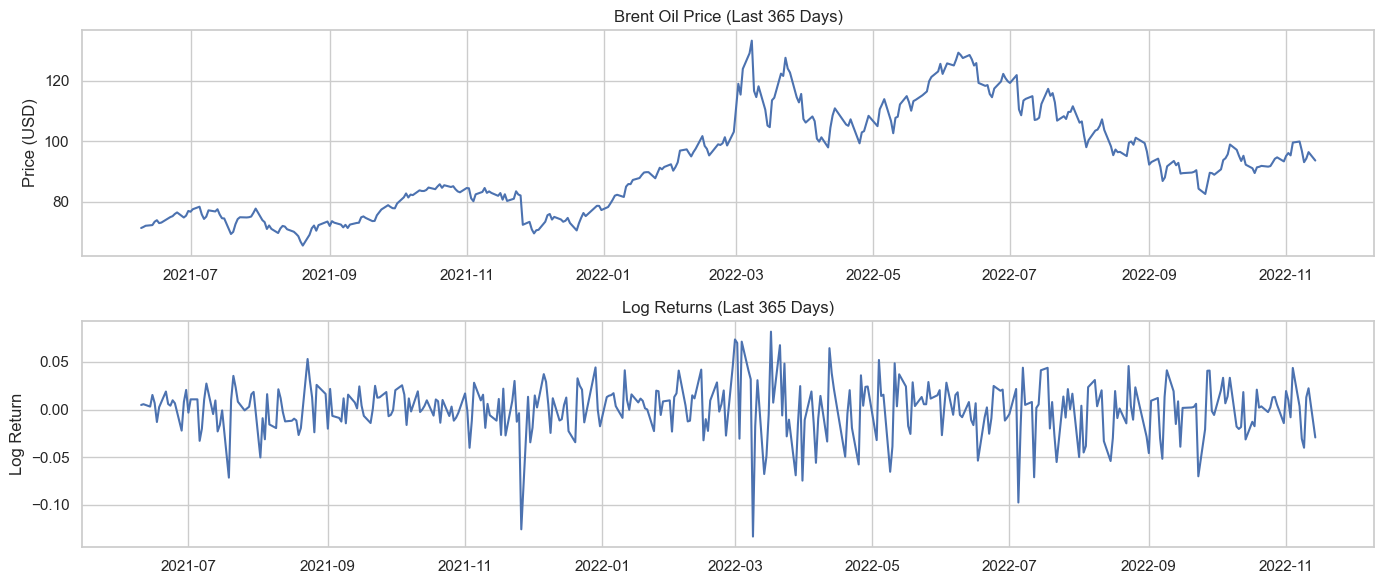

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 331 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


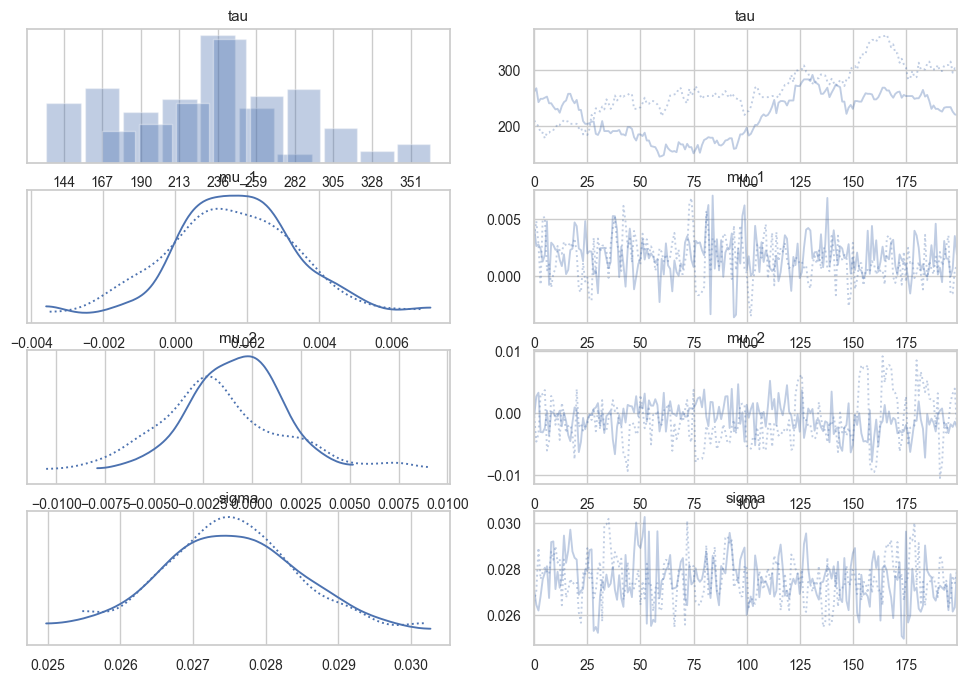

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,241.298,46.873,150.000,315.000,26.791,11.633,3.0,21.0,1.81
mu_1,0.002,0.002,-0.002,0.005,0.000,0.000,163.0,212.0,1.03
mu_2,-0.001,0.003,-0.007,0.005,0.000,0.001,137.0,110.0,1.04
sigma,0.028,0.001,0.025,0.029,0.000,0.000,204.0,169.0,1.01


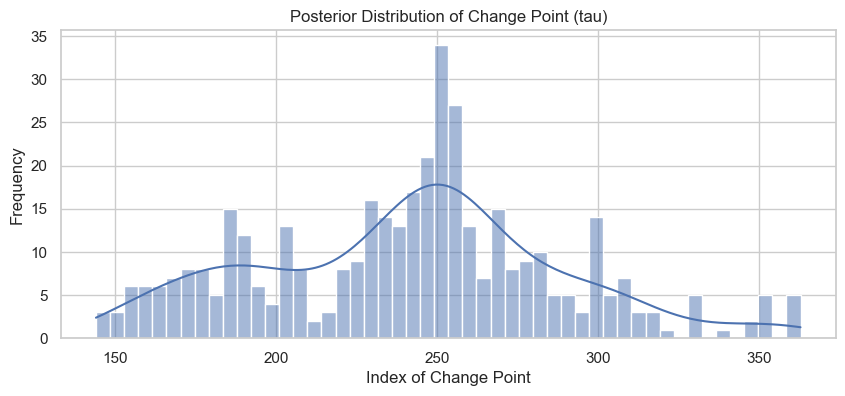

Most probable change point date: 2022-05-30T00:00:00.000000000
Mean log return before change: 0.00167
Mean log return after change: -0.00115
Percent change in mean log return: -168.54%


In [7]:
# --- Task 2: Bayesian Change Point Analysis (Expert Workflow) ---
import pymc as pm

# Use a manageable subset for demonstration (e.g., last 365 days)
subset_df = brent_df.tail(365).copy()
prices = subset_df['Price'].values
log_returns = np.log(prices[1:] / prices[:-1])
dates = subset_df['Date'].values[1:]

# Plot price and log returns
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(subset_df['Date'], subset_df['Price'])
plt.title('Brent Oil Price (Last 365 Days)')
plt.ylabel('Price (USD)')
plt.subplot(2, 1, 2)
plt.plot(dates, log_returns)
plt.title('Log Returns (Last 365 Days)')
plt.ylabel('Log Return')
plt.tight_layout()
plt.show()

# Bayesian Change Point Model
with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(log_returns)-1)
    mu_1 = pm.Normal('mu_1', mu=np.mean(log_returns), sigma=np.std(log_returns))
    mu_2 = pm.Normal('mu_2', mu=np.mean(log_returns), sigma=np.std(log_returns))
    sigma = pm.HalfNormal('sigma', sigma=np.std(log_returns))
    mu = pm.math.switch(tau >= np.arange(len(log_returns)), mu_1, mu_2)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)
    trace = pm.sample(200, tune=200, cores=2, target_accept=0.95, random_seed=42)

# Diagnostics
pm.plot_trace(trace)
plt.show()
summary = pm.summary(trace)
display(summary)

# Posterior of change point
tau_samples = trace.posterior['tau'].values.flatten()
plt.figure(figsize=(10, 4))
sns.histplot(tau_samples, bins=50, kde=True)
plt.title('Posterior Distribution of Change Point (tau)')
plt.xlabel('Index of Change Point')
plt.ylabel('Frequency')
plt.show()

# Map change point index to date
change_date = dates[int(np.median(tau_samples))]
print(f"Most probable change point date: {change_date}")

# Quantify impact
mu_1_samples = trace.posterior['mu_1'].values.flatten()
mu_2_samples = trace.posterior['mu_2'].values.flatten()
mean_before = np.mean(mu_1_samples)
mean_after = np.mean(mu_2_samples)
print(f"Mean log return before change: {mean_before:.5f}")
print(f"Mean log return after change: {mean_after:.5f}")
impact = (mean_after - mean_before) / abs(mean_before) * 100
print(f"Percent change in mean log return: {impact:.2f}%")

C:\Users\pc\AppData\Local\Temp\ipykernel_13020\4071493952.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce', infer_datetime_format=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_13020\4071493952.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce', infer_datetime_format=True)


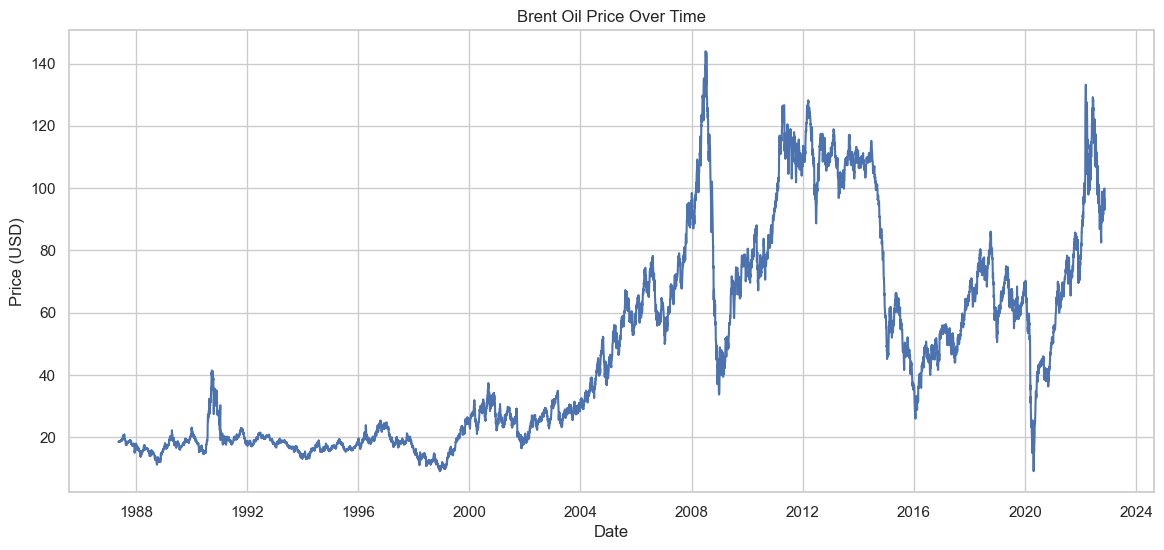

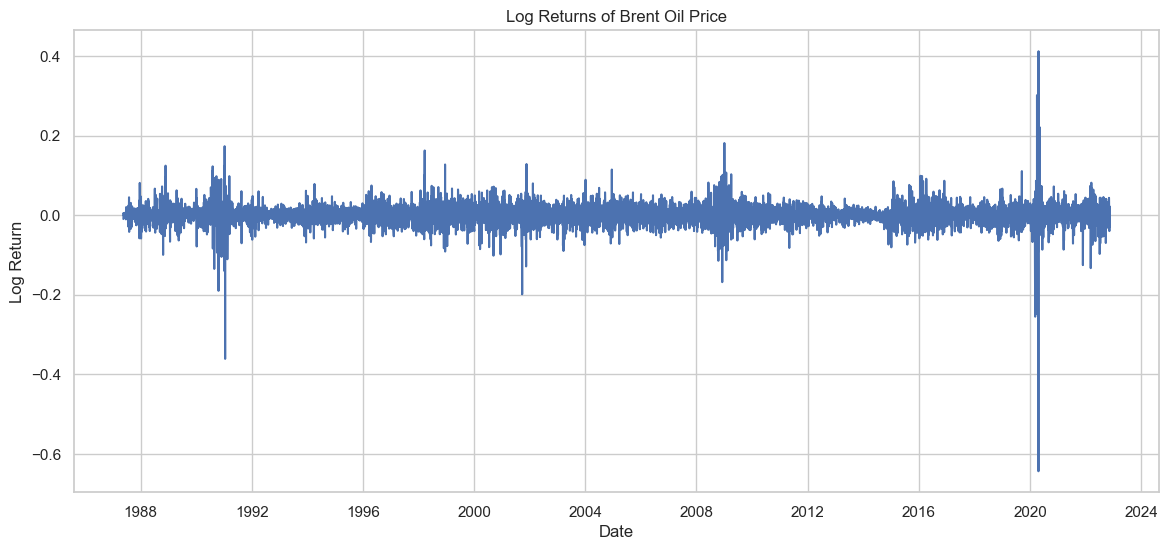

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 90 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


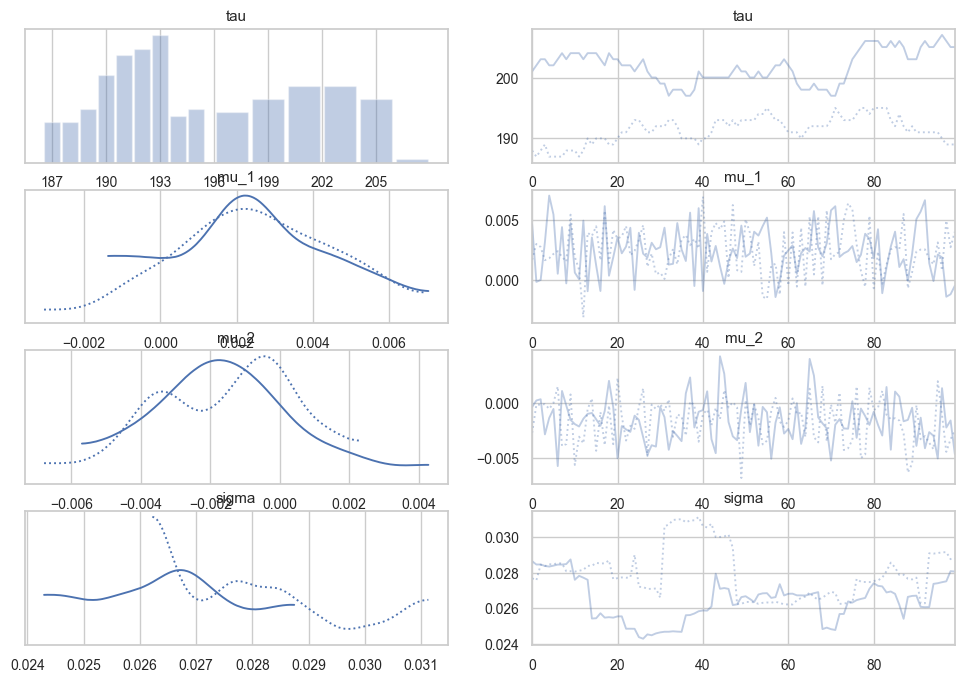

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,196.600,5.778,187.000,205.000,3.658,0.65,3.0,10.0,2.04
mu_1,0.002,0.002,-0.001,0.006,0.000,0.00,208.0,156.0,1.00
mu_2,-0.002,0.002,-0.005,0.002,0.000,0.00,219.0,155.0,0.99
sigma,0.027,0.002,0.024,0.031,0.001,0.00,6.0,18.0,1.33


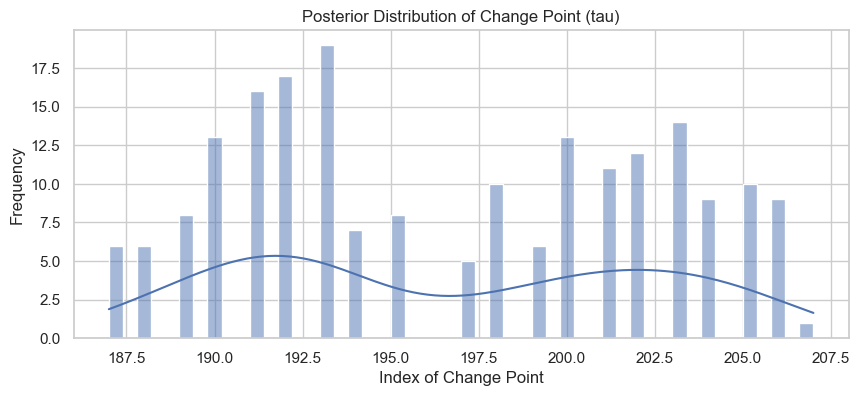

Most probable change point date: 2022-03-16T00:00:00.000000000
Mean log return before change: 0.00246
Mean log return after change: -0.00158
Percent change in mean log return: -164.06%


In [8]:
# --- Task 2: Bayesian Change Point Analysis (Full Workflow) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

# 1. Data Preparation
brent_df = pd.read_csv('../data/BrentOilPrices.csv')
brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce', infer_datetime_format=True)
brent_df = brent_df.sort_values('Date')

# 2. EDA: Plot price and log returns
plt.figure(figsize=(14, 6))
plt.plot(brent_df['Date'], brent_df['Price'])
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

prices = brent_df['Price'].values
log_returns = np.log(prices[1:] / prices[:-1])
dates = brent_df['Date'].values[1:]

plt.figure(figsize=(14, 6))
plt.plot(dates, log_returns)
plt.title('Log Returns of Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

# 3. Bayesian Change Point Model (on a manageable subset for speed)
subset_len = 365  # Use last 365 days for demonstration
subset_prices = prices[-subset_len:]
subset_log_returns = np.log(subset_prices[1:] / subset_prices[:-1])
subset_dates = dates[-(subset_len-1):]

with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(subset_log_returns)-1)
    mu_1 = pm.Normal('mu_1', mu=np.mean(subset_log_returns), sigma=np.std(subset_log_returns))
    mu_2 = pm.Normal('mu_2', mu=np.mean(subset_log_returns), sigma=np.std(subset_log_returns))
    sigma = pm.HalfNormal('sigma', sigma=np.std(subset_log_returns))
    mu = pm.math.switch(tau >= np.arange(len(subset_log_returns)), mu_1, mu_2)
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=subset_log_returns)
    trace = pm.sample(100, tune=100, cores=2, target_accept=0.95, random_seed=42)

# 4. Diagnostics
pm.plot_trace(trace)
plt.show()
summary = pm.summary(trace)
display(summary)

# 5. Posterior of change point
tau_samples = trace.posterior['tau'].values.flatten()
plt.figure(figsize=(10, 4))
sns.histplot(tau_samples, bins=50, kde=True)
plt.title('Posterior Distribution of Change Point (tau)')
plt.xlabel('Index of Change Point')
plt.ylabel('Frequency')
plt.show()

# 6. Map change point index to date
change_date = subset_dates[int(np.median(tau_samples))]
print(f"Most probable change point date: {change_date}")

# 7. Quantify impact
mu_1_samples = trace.posterior['mu_1'].values.flatten()
mu_2_samples = trace.posterior['mu_2'].values.flatten()
mean_before = np.mean(mu_1_samples)
mean_after = np.mean(mu_2_samples)
print(f"Mean log return before change: {mean_before:.5f}")
print(f"Mean log return after change: {mean_after:.5f}")
impact = (mean_after - mean_before) / abs(mean_before) * 100
print(f"Percent change in mean log return: {impact:.2f}%")

## Advanced Extensions & Future Work

- Incorporate additional explanatory variables (e.g., GDP, inflation, exchange rates) for richer models.
- Explore advanced time series models: VAR for dynamic relationships, Markov-Switching for regime changes.
- Build interactive dashboards for stakeholder communication.
- Refine event association using causal inference techniques.